In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#IMPORTANT: Please change PATH according to your Google Drive's path to the "Images" directory
#by clicking the three dots next to the "Images" folder and selecting "Copy path"
PATH = '/content/drive/MyDrive/FISIKA/Images'

train_dir = os.path.join(PATH, 'Training')
validation_dir = os.path.join(PATH, 'Validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 459 files belonging to 9 classes.
Found 117 files belonging to 9 classes.


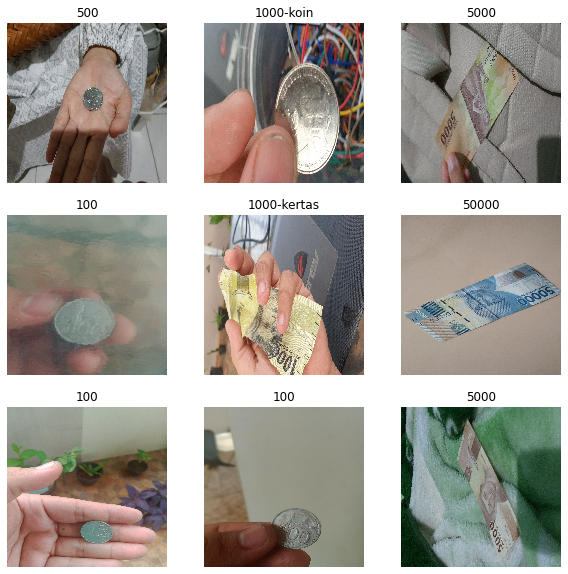

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

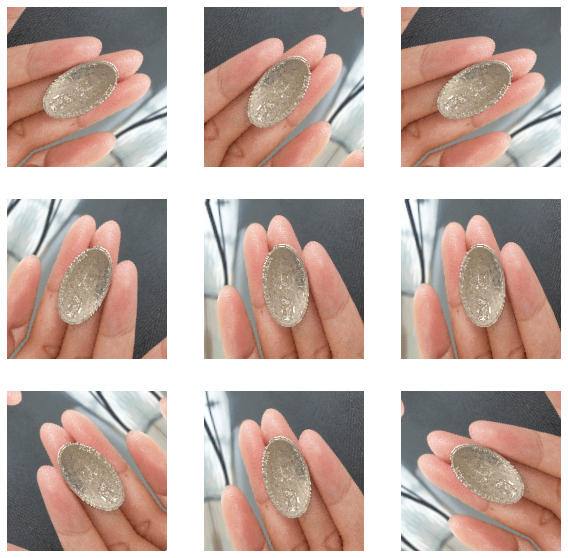

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=9)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
base_model.summary()

(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 9)


In [ ]:
inputs =  tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 55s 121ms/step - loss: 2.8552 - accuracy: 0.1282


In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
15/15 [==============================] - 96s 6s/step - loss: 2.1178 - accuracy: 0.2789 - val_loss: 1.3363 - val_accuracy: 0.5214
Epoch 2/10
15/15 [==============================] - 31s 1s/step - loss: 1.0358 - accuracy: 0.6514 - val_loss: 0.8485 - val_accuracy: 0.7179
Epoch 3/10
15/15 [==============================] - 31s 1s/step - loss: 0.6580 - accuracy: 0.7821 - val_loss: 0.6083 - val_accuracy: 0.8291
Epoch 4/10
15/15 [==============================] - 31s 1s/step - loss: 0.4686 - accuracy: 0.8780 - val_loss: 0.5184 - val_accuracy: 0.8462
Epoch 5/10
15/15 [==============================] - 31s 1s/step - loss: 0.3475 - accuracy: 0.9085 - val_loss: 0.4387 - val_accuracy: 0.8974
Epoch 6/10
15/15 [==============================] - 32s 1s/step - loss: 0.2893 - accuracy: 0.9107 - val_loss: 0.4168 - val_accuracy: 0.8803
Epoch 7/10
15/15 [==============================] - 31s 1s/step - loss: 0.2508 - accuracy: 0.9281 - val_loss: 0.3963 - val_accuracy: 0.8803
Epoch 8/10
15/15 [==

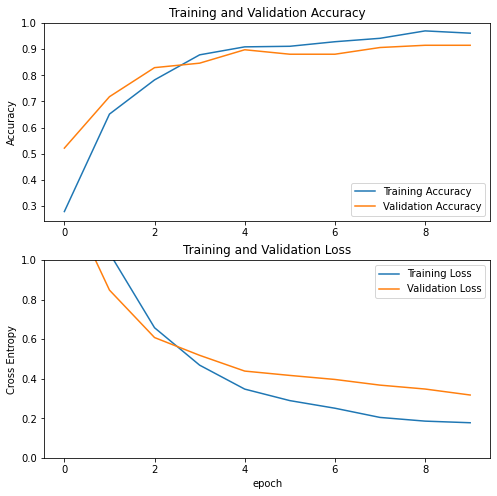

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#RUN THIS TO UPLAD AN IMAGE AND PREDICT IT

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  img_read = cv2.imread(path)
  cv2_imshow(img_read)

Saving photo1626445369 (1).jpeg to photo1626445369 (1).jpeg


In [ ]:
#RUN THIS TO GET THE RESULT

result = classes[0].tolist()
if max(result) == result[0]:
  print('Rp 100')
elif max(result) == result[1]:
  print('Rp 1.000-kertas')
elif max(result) == result[2]:
  print('Rp 1.000-koin')
elif max(result) == result[3]:
  print('Rp 100.000')
elif max(result) == result[4]:
  print('Rp 200')
elif max(result) == result[5]:
  print('Rp 20.000')
elif max(result) == result[6]:
  print('Rp 500')
elif max(result) == result[7]:
  print('Rp 5.000')
elif max(result) == result[8]:
  print('Rp 50.000')
else:
  print('Not defined')

Rp 20.000


In [ ]:
#IF YOU'RE SATISFIED WITH THE RESULT, RUN THIS CELL TO SAVE THE MODEL
!mkdir -p saved_model
model.save('saved_model/my_model')

model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
#RUN THIS CELL TO DOWNLOAD THE SAVED MODEL
!zip -r saved_model.zip /content/saved_model

from google.colab import files
files.download("saved_model.zip")
files.download("/content/my_model.h5")

updating: content/saved_model/ (stored 0%)
updating: content/saved_model/my_model/ (stored 0%)
updating: content/saved_model/my_model/assets/ (stored 0%)
updating: content/saved_model/my_model/keras_metadata.pb (deflated 96%)
updating: content/saved_model/my_model/saved_model.pb (deflated 92%)
updating: content/saved_model/my_model/variables/ (stored 0%)
updating: content/saved_model/my_model/variables/variables.index (deflated 75%)
updating: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>